<a href="https://colab.research.google.com/github/mong-head/cha_cha_PKL/blob/master/jupyter_file/pklot_cha2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parking Lot Space Availability CNN (차차)**
This convolutional neural network performs binary classification task on visual input of a parking lot. Possible classes for individual parking lot spaces are empty and occupied. The segmentation of the image is done through the use of coordinates imported from a csv file.

# **Code Initialization**
Modules and library imports, and mounting of drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
import tarfile
tar = tarfile.open("/content/drive/Shared drives/parkinglot/CNR-EXT_FULL_IMAGE_1000x750/CNR-EXT_FULL_IMAGE_1000x750.tar")
tar.extractall(path="/content/drive/Shared drives/parkinglot/CNR-EXT_FULL_IMAGE_1000x750/")
'''

In [ ]:
#!unzip "/content/drive/Shared drives/parkinglot/CNR-EXT-Patches-150x150.zip"

In [ ]:
#Future imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#Utils imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
from datetime import datetime
from PIL import Image
import cv2
import pickle as pkl

#Tensorflow imports
import tensorflow as tf
from tensorflow import keras
try:
    %tensorflow_version 2.x
except Exception:
    pass

#Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.utils import compute_class_weight

#Keras imports
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import normalize
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model

TensorFlow is already loaded. Please restart the runtime to change versions.


Using TensorFlow backend.


# **Definition of Global Variables**
Initialization of global variables that will be used through the entire code, these include the directory of the dataset, the logs, saved models, and input image parameters.

In [ ]:
#Global variables definition
file_path = '/content/drive/Shared drives/parkinglot/'
model_path = file_path+'Best Model.hdf5'
logdir = file_path+"IBML-Final-Project/Training Logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
#Image parameters
image_width = 150
image_height = 150
channels = 3

# **Data Acquisition**
Acquisition of empty and ocupied data instances, as well as the datset's ground truth. The images are attached to a numpy multidimensional array. Both classes are concatenated into a single array for inputs, and a single array for targets, and subsequently stored in a pickle file to be used later if necessary.

In [ ]:
class DataAcquisition():
    #Acquire busy class
    def busy_acquisition(image_width, image_height, channels):
        dir_path = file_path+'Dataset/Training/Training Set/Occupied/'
        X_busy = np.ndarray(shape=(len(os.listdir(dir_path)), image_height, image_width, channels), dtype=np.float32)
        for filename in os.listdir(dir_path):
            image_path = dir_path+filename
            print(str(len(os.listdir(dir_path))-(os.listdir(dir_path).index(filename)+1))+' files left in busy class')
            img = cv2.imread(image_path)
            img = cv2.resize(img, (150, 150))
            X_busy[os.listdir(dir_path).index(filename)] = img
        print(X_busy.shape)
        y_busy = np.ones((len(X_busy),1))
        return X_busy, y_busy

    #Acquire free class
    def free_acquisition(image_width, image_height, channels):
        dir_path = file_path+'Dataset/Training/Training Set/Empty/'
        X_free = np.ndarray(shape=(len(os.listdir(dir_path)), image_height, image_width, channels), dtype=np.float32)
        print('X_free shape:'+str(X_free.shape))
        for filename in os.listdir(dir_path):
            image_path = dir_path+filename
            print(str(len(os.listdir(dir_path))-(os.listdir(dir_path).index(filename)+1))+' files left in free class')
            img = cv2.imread(image_path)
            img = cv2.resize(img, (150, 150))
            X_free[os.listdir(dir_path).index(filename)] = img
        print(os.listdir(dir_path).index)
        y_free = np.zeros((len(X_free),1))
        return X_free, y_free

    #Concatenate the dataset
    def concatenate_dataset(X_busy, X_free, y_busy, y_free):
        length = len(X_busy) + len(X_free)
        print(length)
        X_raw = np.ndarray(shape=(length, image_height, image_width, channels), dtype=np.float32)
        for i in range(len(X_busy)):
            X_raw[i] = X_busy[i]
        for x in range(len(X_free)):
            X_raw[i+x+1] = X_free[x]
        y_raw = np.append(y_busy, y_free)
        return X_raw, y_raw

    #Save dataset to file
    def save_dataset(X_raw, y_raw, file_path, X_busy, X_free, y_busy, y_free):
        np.savez((file_path+'IBML-Final-Project/Car Dataset v2.npz'), inputs_busy=X_busy, targets_busy=y_busy, inputs_free=X_free, targets_free=y_free)
        print('Saved!')

    #Load dataset from file
    def load_dataset(file_path):
        dataset = np.load((file_path+'IBML-Final-Project/Car Dataset v2.npz'))
        X_raw = dataset['inputs']
        y_raw = dataset['targets']
        print('Loaded!')
        return X_raw, y_raw

# **CNN Architechture Definition**
VGG19 is used as a base model for transfer learning, and additional layers are added, non-linear activation functions "selu" and "relu" are used for these layers, and the final layer uses "softmax" activation. Since the task involves binary classification, categorical crossentropy is used as the loss function. Hyperparameters of stochastic gradient descent, the optimizer selected for this architecture, include learning rate, learning rate decay, momentum, and dropout. A list of callbacks is defined to monitor and store logs of training, as well as saving the best overall model every epoch. Class weights are calculated to ensure that the dataset will not skew training through class imbalancement. Finally, the model is fitted.

In [ ]:
class ModelDefinition():

    def create_model(optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), dropout=0.1, init='uniform'):
      #Parameters
      loss_list = "categorical_crossentropy"
      test_metrics = 'accuracy'
      model_input = keras.Input(shape=(150, 150, 3))

      #Base model
      base_model = VGG19(weights='imagenet', include_top=False)
      for layer in base_model.layers[:]:
          layer.trainable = False
      x = base_model(model_input)
      x = keras.layers.GlobalAveragePooling2D()(x)
      x = keras.layers.Dense(150, activation="selu", kernel_initializer=init)(x)
      x = keras.layers.Dropout(dropout)(x)
      x = keras.layers.Dense(150, activation="selu")(x)
      x = keras.layers.Dropout(dropout)(x)

      #Output net
      y1 = keras.layers.Dense(128, activation='relu')(x)
      y1 = keras.layers.Dropout(dropout)(y1)
      y1 = keras.layers.Dense(64, activation='relu')(y1)
      y1 = keras.layers.Dropout(dropout)(y1)
      y1 = keras.layers.Dense(16, activation='relu')(y1)
      y1 = keras.layers.Dropout(dropout)(y1)

      #Net connections to output layer
      y1 = keras.layers.Dense(2, activation='softmax')(y1)

      #Model compilation
      model = keras.models.Model(inputs=model_input, outputs=y1)
      model.compile(loss=loss_list,
                    optimizer=optimizer,
                    metrics=['accuracy'])
      return model

    #Model checkpoint for most accurate model selection
    def define_callbacks(model_path, logdir):
        checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        callbacks_list = [checkpoint, tensorboard_callback]
        return callbacks_list

    #Compute class weights
    def class_weights(y_train, y_valid):
        class_weight_list = compute_class_weight('balanced', np.unique(y_train), y_train)
        classWeight = dict(zip(np.unique(y_train), class_weight_list))
        y_train=keras.utils.to_categorical(y_train, 2)
        y_valid=keras.utils.to_categorical(y_valid, 2) 
        return classWeight, y_train, y_valid

    #Model fit training
    def fit_train(X_train, X_valid, y_train, y_valid):
        history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid), 
                    callbacks=callbacks_list, class_weight=classWeight)
        return history

# **Model Training**
Block that combines multiple classes and methods to generate the dataset, define the model, and subsequently train it.

In [ ]:
class ModelTraining():
    def do_stuff(image_width, image_height, channels, file_path):
        X_busy, y_busy = DataAcquisition.busy_acquisition(image_width, image_height, channels)
        X_free, y_free = DataAcquisition.free_acquisition(image_width, image_height, channels)
        X_raw, y_raw = DataAcquisition.concatenate_dataset(X_busy, X_free, y_busy, y_free)
        DataAcquisition.save_dataset(X_raw, y_raw, file_path, X_busy, X_free, y_busy, y_free)
        
        X_raw, y_raw = DataAcquisition.load_dataset(file_path)
        X_train, X_valid, y_train, y_valid = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)
        model = ModelDefinition.create_model()
        callbacks_list = ModelDefinition.define_callbacks(model_path, logdir)
        classWeight, y_train, y_valid = ModelDefinition.class_weights(y_train, y_valid)
        history = ModelDefinition.fit_train(X_train, X_valid, y_train, y_valid)

# **Test Image Segmentation**
Reads parking lot space coordinates from a csv file, and stores them in variables in order to generate patches in the image for cropping. The cropped images correspond to the seg

In [ ]:
class ParkingLotSegmentation():
    def crop_image(img, x1, y1, x2, y2, x3, y3, x4, y4):
        top_left_x = min([x1,x2,x3,x4])
        top_left_y = min([y1,y2,y3,y4])
        bot_right_x = max([x1,x2,x3,x4])
        bot_right_y = max([y1,y2,y3,y4])
        roi = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
        return roi

    def define_patches(model, img, ax, ID, x, y, lot_width, lot_height, center_x, center_y, lot_angle, vacancy):
        cont = 0
        for i in range(len(ID)):
            patch_shape = np.ndarray((4,2))
            patch_shape[0,0] = float(x[i+cont])
            patch_shape[0,1] = float(y[i+cont])
            patch_shape[1,0] = float(x[i+cont+1])
            patch_shape[1,1] = float(y[i+cont+1])
            patch_shape[2,0] = float(x[i+cont+2])
            patch_shape[2,1] = float(y[i+cont+2])
            patch_shape[3,0] = float(x[i+cont+3])
            patch_shape[3,1] = float(y[i+cont+3])
            cont = cont + 3
            roi = ParkingLotSegmentation.crop_image(img, int(patch_shape[0,0]), int(patch_shape[0,1]), int(patch_shape[1,0]), int(patch_shape[1,1]), int(patch_shape[2,0]), int(patch_shape[2,1]), int(patch_shape[3,0]), int(patch_shape[3,1]))
            roi = cv2.resize(roi, (150, 150))
            roi_tr = np.ndarray(shape=(1,150,150,3), dtype=np.float32)
            roi_tr = np.expand_dims(roi, axis=0).astype(np.float32)
            prediction = model.predict(roi_tr)
            print('Slot '+str(ID[i])+': '+str(np.argmax(prediction)))
            if np.argmax(prediction) == 0.0:
                rect = patches.Polygon(patch_shape, linewidth=1,edgecolor='g',facecolor='none')
            else:
                rect = patches.Polygon(patch_shape, linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

    def csv_input(img, ax, file_path, model,camara_csv):
        with open(file_path+camara_csv, newline='') as csvfile:
            lot_csv = reader = csv.DictReader(csvfile)
            #img = cv2.resize(img,(2592,1944))
            free = 0  #add : free space num
    
            for row in lot_csv:
                #crop_img = img[(int(row['Y'])-int(row['H'])/2):(int(row['Y'])-int(row['H'])/2)+int(row['H']), (int(row['X'])-int(row['W'])/2):(int(row['X'])-int(row['W'])/2)+int(row['W'])]      
                #crop_img = img[int((int(row['Y'])-int(row['H'])/2)):int((int(row['Y'])-int(row['H'])/2)+int(row['H'])), int((int(row['X'])-int(row['W'])/2)):int((int(row['X'])-int(row['W'])/2)+int(row['W']))]
                crop_img = img[int(row['Y']):int(row['Y'])+int(row['H']) , int(row['X']):int(row['X'])+int(row['W'])]
                #roi = cv2.resize(roi, (150, 150))
                
                roi = cv2.resize(crop_img, (150, 150))
                roi_tr = np.ndarray(shape=(1,150,150,3), dtype=np.float32)
                roi_tr = np.expand_dims(roi, axis=0).astype(np.float32)
                prediction = model.predict(roi_tr)
                #print(str(np.argmax(prediction)))
                if np.argmax(prediction) == 0.0:
                    ec='g'
                    free = free + 1
                else:
                    ec='r'
                    
                #rect  = patches.Rectangle(((int(row['X'])-int(row['W'])/2), (int(row['Y'])-int(row['H'])/2)), int(row['W']), int(row['H']), edgecolor=ec, facecolor='none') 
                #rect  = patches.Rectangle(int((int(row['X'])/2.592), int((int(row['Y']))/2.592), int(int(row['W'])/2.592), int(int(row['H'])/2.592), edgecolor=ec, facecolor='none'))
                rect  = patches.Rectangle((int(row['X']), int(row['Y'])), int(row['W']), int(row['H']), edgecolor=ec, facecolor='none')
                ax.add_patch(rect)
        return free

# **Testing**
Takes a parking lot image as an input, segments it using the coordinates from the provided csv file, and subsequently runs each segment through the classifier's predictor. The results are then graphed into the original image, representing the classes by green patches, if empty, and red patches, if occupied.

In [ ]:
class ModelTesting():
    def predict_vacancy(file_path):
        #Load trained model
        model = load_model(model_path)
        print('done!')

        #Segment parking lot
        parkinglot_img_list = ['CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-16/camera8/2015-11-16_1708.jpg',
                               'CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-16/camera8/2015-11-16_0722.jpg',
                               'CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/RAINY/2016-02-12/camera9/2016-02-12_1742.jpg',
                               'CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/SUNNY/2015-11-27/camera1/2015-11-27_1640.jpg',
                               'school_1_2592.jpg','school_2_2592.jpg','school_3_2592.jpg']
        camera_csv_list = ['CNR-EXT_FULL_IMAGE_1000x750/camera8.csv',
                           'CNR-EXT_FULL_IMAGE_1000x750/camera8.csv',
                           'CNR-EXT_FULL_IMAGE_1000x750/camera9.csv',
                           'CNR-EXT_FULL_IMAGE_1000x750/camera1.csv',
                           'school.csv','school.csv','school2.csv']
        for i in range(len(parkinglot_img_list)):
           #Read parking lot image
           img = cv2.imread(file_path+parkinglot_img_list[i])
           fig,ax = plt.subplots(figsize=(10, 10))
           img = cv2.resize(img,(2592,1944)) #plus

           #Generate patches
           #ParkingLotSegmentation.define_patches(model, img, ax, ID, x, y, lot_width, lot_height, center_x, center_y, lot_angle, vacancy)
           free_num = ParkingLotSegmentation.csv_input(img, ax, file_path, model,camera_csv_list[i])
           ax.imshow(img)
           plt.show()
           print('free space : ',free_num)

# **If __main__ Statement**
End of the code!

done!


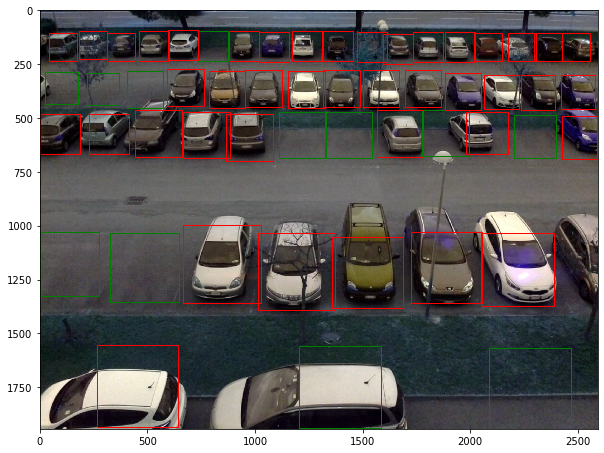

free space :  12


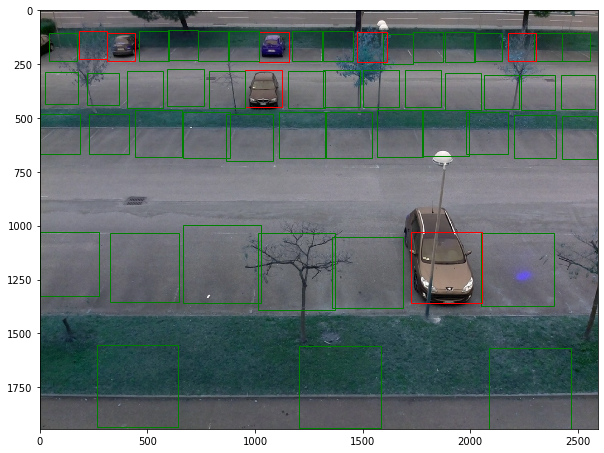

free space :  47


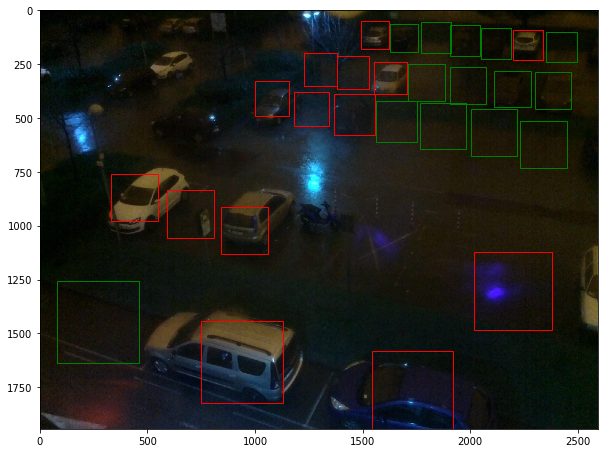

free space :  14


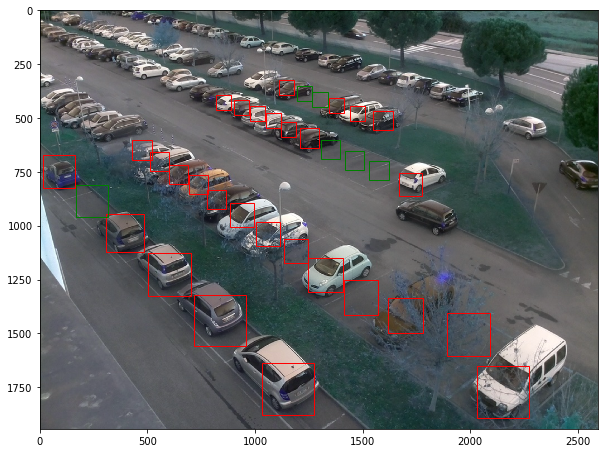

free space :  6


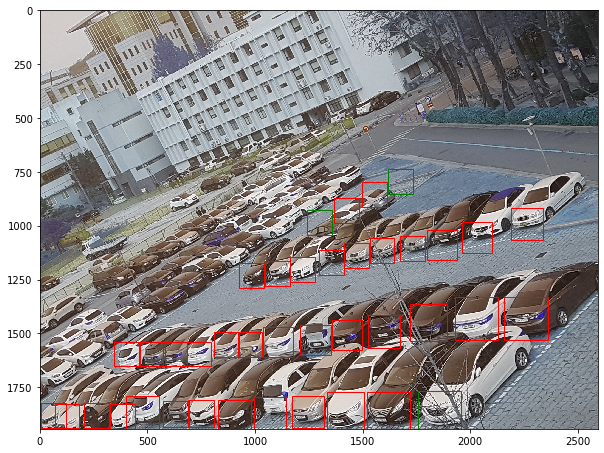

free space :  3


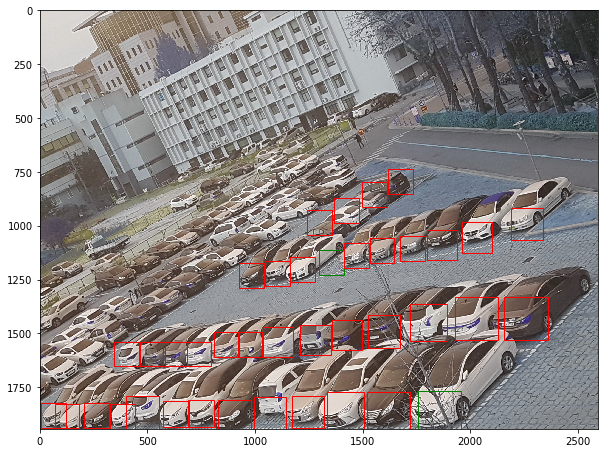

free space :  2


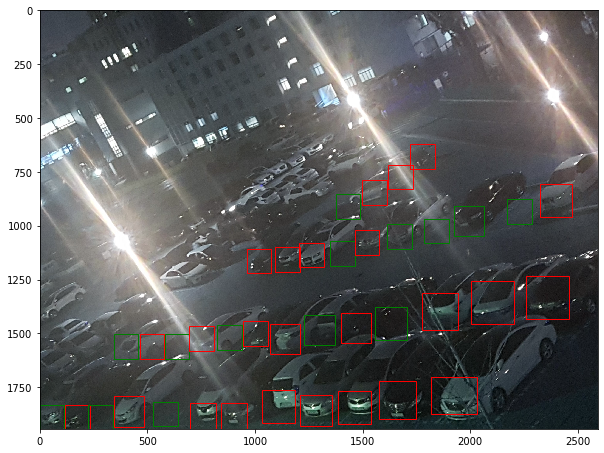

free space :  14


In [ ]:
if __name__ == "__main__":
    #ModelTraining.do_stuff(image_width, image_height, channels, file_path)
    vacancy = ModelTesting.predict_vacancy(file_path)